<a href="https://colab.research.google.com/github/marcinwolter/MCtuning/blob/master/MC_tuning_toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generate some data

In [35]:
#Define dimensionality

import numpy as np

# data dimensionality
n_dim = 1

# size of generated samples
n_size = 1000

# number of hyperopt iterations
nIter = 100


# Parameters of the generated gaussian
par = np.array([1.,2.])


Generator

In [36]:
'''
def generator(batch_size, par_0, par_fit):

  X_batch  = np.zeros((batch_size, n_dim))
  y_batch  = np.zeros((batch_size, 1))

  event = np.zeros( n_dim)

  while True:
   for n in range(batch_size):
    if np.random.randint(0,2):
      for k in range(n_dim):
        X_batch[n,k] = np.random.normal(loc=par_0[0+2*k], scale=par_0[1+2*k], size=None)
      y_batch[n,0] = 0
    else:
      for k in range(n_dim):
        X_batch[n,k] = np.random.normal(loc=par_fit[0+2*k], scale=par_fit[1+2*k], size=None)
      y_batch[n,0] = 1       


   #print(X_batch,y_batch)
    
   yield X_batch, y_batch
'''


'\ndef generator(batch_size, par_0, par_fit):\n\n  X_batch  = np.zeros((batch_size, n_dim))\n  y_batch  = np.zeros((batch_size, 1))\n\n  event = np.zeros( n_dim)\n\n  while True:\n   for n in range(batch_size):\n    if np.random.randint(0,2):\n      for k in range(n_dim):\n        X_batch[n,k] = np.random.normal(loc=par_0[0+2*k], scale=par_0[1+2*k], size=None)\n      y_batch[n,0] = 0\n    else:\n      for k in range(n_dim):\n        X_batch[n,k] = np.random.normal(loc=par_fit[0+2*k], scale=par_fit[1+2*k], size=None)\n      y_batch[n,0] = 1       \n\n\n   #print(X_batch,y_batch)\n    \n   yield X_batch, y_batch\n'

In [37]:
def generator(n_size, par, ev_class):

  X_batch  = np.zeros((n_size, n_dim))
  y_batch  = np.zeros((n_size, 1))

  event = np.zeros( n_dim)

  while True:
   for n in range(n_size):
      for k in range(n_dim):
        X_batch[n,k] = np.random.normal(loc=par[0+2*k], scale=par[1+2*k], size=None)
      y_batch[n,0] = ev_class
       


   #print(X_batch,y_batch)
    
   return X_batch, y_batch



Deep neural network

In [38]:

def model_nn():
  from keras.datasets import mnist
  from keras.models import Sequential
  from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
  from keras.layers.convolutional import Convolution1D, Convolution2D, MaxPooling2D
  from keras.utils import np_utils


  model = Sequential()
  model.add(Dense(48, activation='relu', input_dim=n_dim))
  model.add(Dense(48, activation='relu'))
  model.add(Dense(48, activation='relu'))
  model.add(Dense(48, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))


  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [39]:

from hyperopt import fmin, tpe, hp
from hyperopt import Trials


# Generate training and validation "data"
ev_class = 1 # generated "data" have class 1
X_data_train, y_data_train = generator(n_size, par, ev_class)
X_data_val,   y_data_val   = generator(n_size, par, ev_class)
# and test data for evaluation
X_data_test,   y_data_test   = generator(n_size, par, ev_class)

# define NN model
model = model_nn()


def f_nn(space):
    p = np.zeros(2*n_dim)
    p[0] = space['p0']
    p[1] = space['p1']
    #p[2] = space['p2']
    #p[3] = space['p3']
    
    # Generate fitted dataset
    ev_class = 0 # generated "data" have class 1
    X_fit_train, y_fit_train = generator(n_size, p, ev_class)
    X_fit_val,   y_fit_val   = generator(n_size, p, ev_class)
    X_fit_test,  y_fit_test  = generator(20*n_size, p, ev_class)
    
    #Concatenate datasets
    X_train = np.concatenate((X_data_train, X_fit_train), axis=0)
    y_train = np.concatenate((y_data_train, y_fit_train), axis=0)
    X_val   = np.concatenate((X_data_val, X_fit_val), axis=0)
    y_val   = np.concatenate((y_data_val, y_fit_val), axis=0)
    X_test  = np.concatenate((X_data_test, X_fit_test), axis=0)
    y_test  = np.concatenate((y_data_test, y_fit_test), axis=0)

    #Train the model using generator vs using the full batch
    batch_size = 32

   
    #print("Training for: ",p)
    cnn = model.fit(
       X_train, y_train,
       epochs=3,
       steps_per_epoch = 100,
       validation_data = (X_val, y_val),
       validation_steps = 2,
       verbose=0
    )

    scores_train = model.evaluate(X_test, y_test, verbose=0)
    ###print("Trials: "+str(len(trials.trials))+" accuracy: "+str(scores_train[1]))   #,trials.trials[len(trials.trials)-1])
    return scores_train[1] 
	
space = {
    'p0': hp.uniform('p0', 0, 3),
    'p1': hp.uniform('p1', 0.1, 3),
    #'p2': hp.uniform('p2', 0, 2),
    #'p3': hp.uniform('p3', 0.1, 3),
}

trials = Trials()

best = fmin(
    fn=f_nn,
    space=space,
    algo=tpe.suggest,
#    algo=tpe.rand.suggest,
    trials=trials,
    max_evals=nIter,
    verbose=1
)



100%|██████████| 100/100 [02:49<00:00,  1.69s/it, best loss: 0.17499999701976776]


In [40]:
# Plots for hyperopt optimization
import matplotlib.pyplot as plt


Text(0.5, 0, '$p1$')

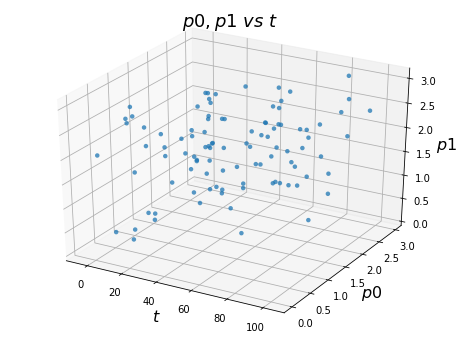

In [41]:
# Visualize results

#f, ax = plt.subplots(1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['p0'] for t in trials.trials]
zs = [t['misc']['vals']['p1'] for t in trials.trials]

ax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys, zs,  linewidth=0.01, alpha=0.75)
ax.set_title('$p0, p1$ $vs$ $t$ ', fontsize=18)
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$p0$', fontsize=16)
ax.set_zlabel('$p1$', fontsize=16)

Text(0, 0.5, '$p0^2 + p1^2$')

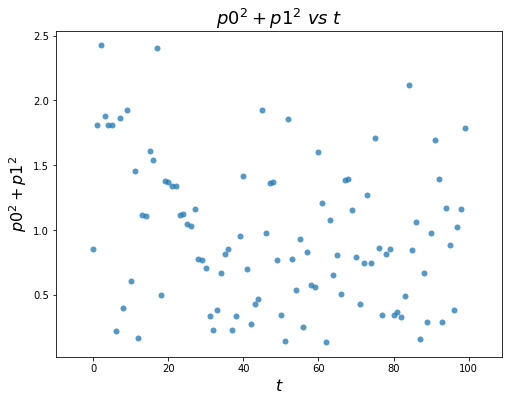

In [47]:
# Visualize results 2d

#f, ax = plt.subplots(1)
fig = plt.figure()
ax = fig.add_subplot(111)

xs = [t['tid'] for t in trials.trials]
p0 = np.array([t['misc']['vals']['p0'] for t in trials.trials])
p1 = np.array([t['misc']['vals']['p1'] for t in trials.trials])
ys = np.sqrt(np.square(p0-1.)+np.square(p1-2.))

ax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys,  linewidth=0.01, alpha=0.75)
ax.set_title('$p0^2 + p1^2$ $vs$ $t$ ', fontsize=18)
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$p0^2 + p1^2$', fontsize=16)


In [43]:

print("Found minimum after ",len(trials.trials)," trials:")
print(best)


#print("Here are the space and results of the 3 first trials (out of a total of 1000):")
#print(trials.trials[0])
#print(trials.trials[1])
#print(trials.trials[2])


#print("What interests us most is the 'result' key of each trial (here, we show 3):")
#print(trials.trials[0]["result"]['loss'])
#print(trials.trials[1]["result"]['loss'])
#print(trials.trials[2]["result"]['loss'])


result = np.zeros(np.size(trials))
for i in range (np.size(result)):
    result[i]=trials.trials[i]["result"]['loss']
#print(trials.trials["result"])
minval = min(result) 
minindex = np.argmin(result)

print("Minimum found :",minval," for parameters: ",trials.trials[minindex]["misc"]["vals"])




Found minimum after  100  trials:
{'p0': 1.1305716551200748, 'p1': 2.191773015675967}
Minimum found : 0.17499999701976776  for parameters:  {'p0': [1.1305716551200748], 'p1': [2.191773015675967]}


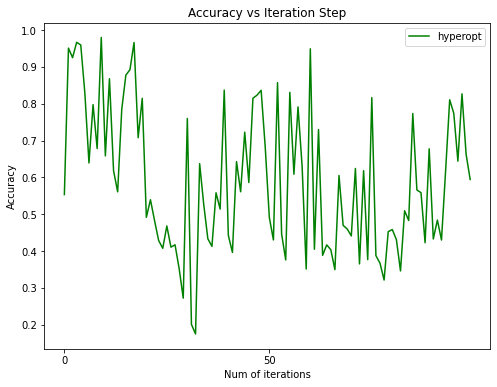

In [44]:

plt.rcParams['figure.figsize'] = (8, 6)

plt.figure(0)

plt.plot(result,'g')
plt.xticks(np.arange(0, len(result), 50.0))
plt.xlabel("Num of iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Iteration Step")
plt.legend(['hyperopt'])
plt.show()



((array([-5.04103402, -4.918962  , -4.79688997, -4.67481795, -4.55274593,
         -4.43067391, -4.30860188, -4.18652986, -4.06445784, -3.94238581,
         -3.82031379, -3.69824177, -3.57616975, -3.45409772, -3.3320257 ,
         -3.20995368, -3.08788166, -2.96580963, -2.84373761, -2.72166559,
         -2.59959357, -2.47752154, -2.35544952, -2.2333775 , -2.11130548,
         -1.98923345, -1.86716143, -1.74508941, -1.62301739, -1.50094536,
         -1.37887334, -1.25680132, -1.13472929, -1.01265727, -0.89058525,
         -0.76851323, -0.6464412 , -0.52436918, -0.40229716, -0.28022514,
         -0.15815311, -0.03608109,  0.08599093,  0.20806295,  0.33013498,
          0.452207  ,  0.57427902,  0.69635104,  0.81842307,  0.94049509,
          1.06256711,  1.18463913,  1.30671116,  1.42878318,  1.5508552 ,
          1.67292723,  1.79499925,  1.91707127,  2.03914329,  2.16121532,
          2.28328734,  2.40535936,  2.52743138,  2.64950341,  2.77157543,
          2.89364745,  3.01571947,  3.

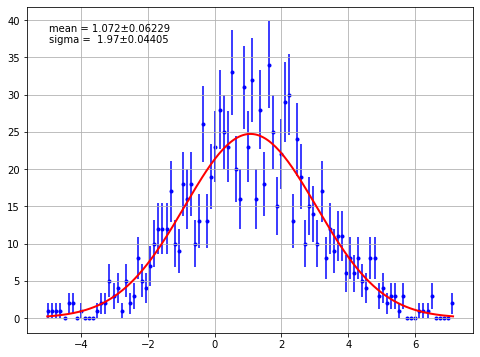

In [45]:
# Unbinned likelihood fit
! pip install iminuit
! pip install probfit

import numpy as np
from iminuit import Minuit
from probfit import UnbinnedLH, gaussian

#data = np.random.randn(10000)
#print(data.shape, X_data_test.shape)
unbinned_likelihood = UnbinnedLH(gaussian, X_data_test.reshape(len(X_data_test),))
minuit = Minuit(unbinned_likelihood, mean=0.1, sigma=1.1)
minuit.migrad()
unbinned_likelihood.draw(minuit)

In [46]:
# scikit-learn bootstrap
from sklearn.utils import resample
import numpy as np

n_bootstrap=1000

# data sample
data = np.random.randn(n_bootstrap)

bmean=np.zeros(n_bootstrap)
for i in range(n_bootstrap):
   # prepare bootstrap sample
  boot = resample(data, replace=True, n_samples=n_bootstrap, random_state=1)
  # print('Bootstrap Sample: %s' % boot)
  # out of bag observations
  # oob = [x for x in data if x not in boot]
  # print('OOB Sample: %s' % oob)
  bmean[i] = np.mean(boot)

boot_mean = np.mean(bmean)
boot_rms  = np.sqrt(np.mean(np.square(bmean-boot_mean)))  

print("bootstrap mean = ",boot_mean,"  bootstrap_rms = ",boot_rms)

bootstrap mean =  -0.0029782528209947806   bootstrap_rms =  4.336808689942018e-19
